In [1]:
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from lensless.plot import plot_image
import numpy as np
import pandas as pd
from pprint import pprint

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs, figsize=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
%load_ext autoreload
%autoreload 2

## Preparing CelebA dataset

Unfortunately using PyTorch utilities for download CelebA crashes due to the huge file size. So we recommend:
1. Downloading the dataset from the original website: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
2. Unzipping the files.
3. Creating a folder called `celeba` which has the files listed in the [source code](https://github.com/pytorch/vision/blob/e0467c64e337c0d1140a9f9a70a413b7268231f4/torchvision/datasets/celeba.py#L47) of PyTorch's CelebA wrapper. Note that you can find `"img_align_celeba.zip"` inside the `Img` folder.
4. You can use the `torchvision.datasets.CelebA` wrapper by providing the folder where `celeb` lies (as shown below).

In [3]:
CELEBA_ROOT_DIR = "/scratch"

# Exploring dataset

In [92]:
downsample = 8    # 594
downsample = 2    # 143

orig_dim = np.array([218, 178])
new_dim = tuple((orig_dim / downsample).astype(int))
print(f"New dimension : {new_dim}")
print(f"Number of hidden dimension : {np.prod(new_dim)}")

# determine output dim so that sensor measurement is
# scaled so that aspect ratio is preserved
from waveprop.devices import SensorOptions, sensor_dict, SensorParam

sensor_param = sensor_dict["rpi_hq"]
sensor_size = sensor_param[SensorParam.SHAPE]
n_hidden = np.prod(new_dim)
w = np.sqrt(n_hidden * sensor_size[1] / sensor_size[0])
h = sensor_size[0] / sensor_size[1] * w
output_dim = (int(np.round(h)), int(np.round(w)))
print(f"Output dimension : {output_dim}")
print(f"Downsampling factor : {sensor_size[1] / w}")

New dimension : (109, 89)
Number of hidden dimension : 9701
Output dimension : (85, 114)
Downsampling factor : 35.651475833408256


In [93]:
# preparin
trans = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,)),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=new_dim)
    ]
)
ds = datasets.CelebA(
    root=CELEBA_ROOT_DIR,
    split="all",
    download=False,
    transform=trans,
)

NameError: name 'datasets' is not defined

In [ ]:
# print dataset info
print(f"Number of files : {len(ds)}")
iden = np.unique(ds.identity.numpy())
print(f"Unique identities : {len(iden)}")
print(f"Attributes : {ds.attr_names}")

Number of files : 202599
Unique identities : 10177
Attributes : ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


In [ ]:
interesting_metadata = ["Male", "Smiling", "Eyeglasses", "Young"]
# interesting_metadata = ds.attr_names[:-1]
metadata_idx = []
for _val in interesting_metadata:
    if _val in ds.attr_names:
        metadata_idx.append(ds.attr_names.index(_val))

print(metadata_idx)

[20, 31, 15, 39]


# plot an image

Shape : torch.Size([3, 218, 178])
Maximum value : 1.0
Minimum value : 0.0

METADATA


NameError: name 'metadata_idx' is not defined

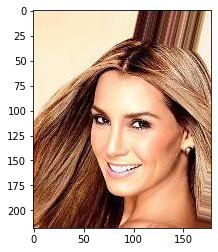

In [94]:
# plot an image
idx = 0
gamma = 1
normalize_plot = True

img, labels = ds[idx]
print(f"Shape : {img.shape}")
print(f"Maximum value : {img.max()}")
print(f"Minimum value : {img.min()}")
input_image_cpu = np.transpose(img.cpu(), (1, 2, 0))
plot_image(input_image_cpu, gamma=gamma, normalize=normalize_plot)

print("\nMETADATA")
metadata_dict = {}
for i in metadata_idx:
    metadata_dict[ds.attr_names[i]] = labels[i].item()
pprint(metadata_dict)

# split dataset equally according to attribute

In [9]:
attr = "Male"
attr_idx = ds.attr_names.index(attr)
labels = ds.attr[:, attr_idx]
df_attr = pd.DataFrame(ds.attr[:, attr_idx])
# df_attr.head()
print(df_attr.value_counts() / len(ds))


0    0.583246
1    0.416754
dtype: float64


In [10]:
from sklearn.model_selection import train_test_split

train_indices, test_indices, y_train, y_val = train_test_split(
    range(len(ds)), labels, test_size=0.1, stratify=labels, random_state=0
)

In [11]:
from torch.utils.data import Subset


train_split = Subset(ds, train_indices)
test_split = Subset(ds, test_indices)
print(len(train_split))
print(len(test_split))

182339
20260


In [12]:
print("train set")
df_attr = pd.DataFrame(ds.attr[train_indices, attr_idx])
print(df_attr.value_counts() / len(df_attr))

print("\ntest set")
df_attr = pd.DataFrame(ds.attr[test_indices, attr_idx])
print(df_attr.value_counts() / len(df_attr))

train set
0    0.583243
1    0.416757
dtype: float64

test set
0    0.583268
1    0.416732
dtype: float64


# metadata distribution
https://pytorch.org/vision/main/_modules/torchvision/datasets/celeba.html#CelebA

In [67]:
attr = pd.DataFrame(ds.attr[:, metadata_idx], columns = interesting_metadata)
attr["identity"] = ds.identity.numpy()
print(attr.shape)
attr.head()

(202599, 41)


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,identity
0,0,1,1,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,2880
1,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,2937
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,8692
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,5805
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,9295


In [68]:
for _attr in interesting_metadata:
    print(f"\n{_attr}")
    print(attr[_attr].value_counts() / len(ds))


5_o_Clock_Shadow
0    0.888864
1    0.111136
Name: 5_o_Clock_Shadow, dtype: float64

Arched_Eyebrows
0    0.733019
1    0.266981
Name: Arched_Eyebrows, dtype: float64

Attractive
1    0.512505
0    0.487495
Name: Attractive, dtype: float64

Bags_Under_Eyes
0    0.795428
1    0.204572
Name: Bags_Under_Eyes, dtype: float64

Bald
0    0.977557
1    0.022443
Name: Bald, dtype: float64

Bangs
0    0.848425
1    0.151575
Name: Bangs, dtype: float64

Big_Lips
0    0.759204
1    0.240796
Name: Big_Lips, dtype: float64

Big_Nose
0    0.765468
1    0.234532
Name: Big_Nose, dtype: float64

Black_Hair
0    0.760749
1    0.239251
Name: Black_Hair, dtype: float64

Blond_Hair
0    0.852008
1    0.147992
Name: Blond_Hair, dtype: float64

Blurry
0    0.949101
1    0.050899
Name: Blurry, dtype: float64

Brown_Hair
0    0.794806
1    0.205194
Name: Brown_Hair, dtype: float64

Bushy_Eyebrows
0    0.857832
1    0.142168
Name: Bushy_Eyebrows, dtype: float64

Chubby
0    0.942433
1    0.057567
Name: Chubby,

In [15]:
attr["identity"].value_counts()[:10]
## NOT ENOUGH IMAGES PER IDENTITY?

3227    35
2820    35
3782    35
3745    34
3699    34
9152    32
8968    32
9256    32
4887    31
6568    31
Name: identity, dtype: int64

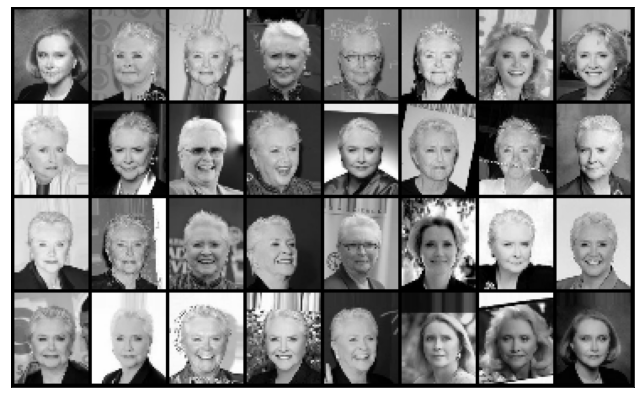

In [16]:
# plot image of one identity
_id = 9152
n_image = 50

image_idx = attr.loc[attr["identity"] == _id].index
imgs = []
for i in range(n_image):
    if i < len(image_idx):
        imgs.append(ds[image_idx[i]][0])
grid = make_grid(imgs)
show(grid, figsize=(18, 7))

# augment with PSF

In [7]:
from lenslessclass.datasets import CelebAPropagated
import numpy as np
from lensless.plot import plot_image

CELEBA_ROOT_DIR = "/scratch"

# down = 19 / 3
# output_dim = (480, 640)
# down = 10
# output_dim = tuple((np.array([3040, 4056]) / down).astype(int))
output_dim = (48, 64)

# psf_fp = "../psfs/tape.png"
# crop_psf = False
# mask2sensor = 4e-3
# down_psf = 8

psf_fp = "../psfs/adafruit.png"
crop_psf = False
mask2sensor = 4e-3
down_psf = 8

# psf_fp = "../psfs/simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit.png"
# crop_psf = False
# mask2sensor = 0.5e-3
# down_psf = 8

# psf_fp = "../psfs/simulated_mls63_mask2sensor0p004_17052022_18h01_12bit.png"
# crop_psf = False
# mask2sensor = 4e-3

# psf_fp = "../psfs/lens.png"
# crop_psf = 100
# down_psf = 1
# mask2sensor = 0.00753

noise_type = "poisson"
snr = 40
object_height = 0.27
grayscale = True
single_psf = False

scene2mask = 40e-2
scene2mask = 55e-2

device_conv = "cuda:1"
# device_conv = "cpu"

sensor = "rpi_hq"
attribute = "Male"

ds_aug = CelebAPropagated(
    psf_fp=psf_fp,
    attribute=attribute,
    downsample_psf=down_psf,
    output_dim=output_dim,
    scene2mask=scene2mask,
    mask2sensor=mask2sensor,
    sensor=sensor,
    object_height=object_height,
    device_conv=device_conv,
    crop_psf=crop_psf,
    grayscale=grayscale,
    vflip=False,
    split="all",
    single_psf=single_psf,
    root=CELEBA_ROOT_DIR,
    noise_type=noise_type,
    snr=snr
)

(380, 507, 1)


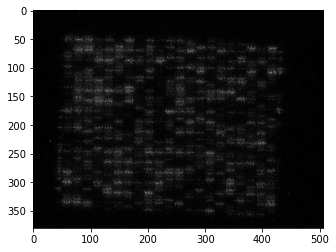

In [8]:
# plot PSF
psf_data = ds_aug.psf.cpu().clone().numpy().transpose(1, 2, 0)
print(psf_data.shape)
ax = plot_image(psf_data, gamma=2.2);

(48, 64, 1)
tensor(0)


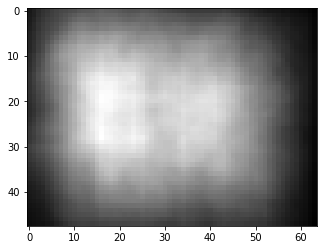

In [9]:
# plot simulated
dataset_idx = 0
img, label = ds_aug[dataset_idx]
# if grayscale:
#     img_data = img.cpu().clone().numpy().squeeze()
# else:
img_data = img.cpu().clone().numpy().transpose(1, 2, 0)
print(img_data.shape)
print(label)
plot_image(img_data);

# Visualizing learned SLM pattern

In [10]:
import pathlib as plib
import json
from pprint import pprint
import torchvision.datasets as dset
import torchvision.transforms as transforms
from lenslessclass.models import MultiClassLogistic, SLMMultiClassLogistic
from lenslessclass.datasets import CelebAAugmented, get_dataset_stats
import torch
import torch.nn as nn
from waveprop.devices import SLMOptions, SensorOptions, slm_dict, sensor_dict, SensorParam
from lensless.plot import plot_image, pixel_histogram
import numpy as np
from sklearn.model_selection import train_test_split

root = "/scratch"
test_per = 0.15
seed = 0
train = False
return_measurement = True     # when applying forward of model

# Single hidden, 35
model_dir = plib.Path("../celeba_no_psf_down8_height0.27_100000files_scene2mask0.55_outdim35_50epoch_seed0_SLMSingleHidden1000_poisson40.0_23082022_15h58")

# Single hidden, 12
model_dir = plib.Path("../celeba_no_psf_down8_height0.27_100000files_scene2mask0.55_outdim12_50epoch_seed0_SLM_SingleHidden1000_poisson40.0_30082022_17h59")


# Opening JSON file
f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
pprint(metadata)

{'attr': 'Male',
 'batch_size': 200,
 'best_test_acc': 0.8869333267211914,
 'best_test_acc_epoch': 48,
 'dataset': '/home/bezzam/LenslessClassification/data_celeba/celeba_no_psf_down8_height0.27_100000files',
 'device_ids': [0, 1],
 'down_orig': None,
 'mean': 0.5,
 'min_val': -0.5,
 'model': 'SLM_SingleHidden1000',
 'model_param': {'cnn_lite': None,
                 'crop_fact': 0.8,
                 'deadspace': True,
                 'device': 'cuda:0',
                 'device_mask_creation': 'cpu',
                 'down': 'resize',
                 'dropout': None,
                 'hidden': 1000,
                 'input_shape': [380, 507],
                 'kernel_size': 3,
                 'mask2sensor': 0.004,
                 'multi_gpu': True,
                 'n_kern': None,
                 'n_slm_mask': 1,
                 'output_dim': [3, 4],
                 'pool': 2,
                 'scene2mask': 0.55},
 'noise_type': 'poisson',
 'seed': 0,
 'sensor': 'rpi_hq',
 'se

In [14]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
ds = dset.CelebA(
    root=root,
    split="all",
    download=False,
    transform=trans,
)
label_idx = ds.attr_names.index(metadata["attr"])

In [15]:
from torch.utils.data import Subset

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
print("\nComputing stats...")

all_data = CelebAAugmented(path=metadata["dataset"], transform=trans)

# get train and test indices
n_files = all_data._n_files
test_size = int(n_files * test_per)
train_size = n_files - test_size
labels = all_data._labels[:, label_idx]
train_indices, test_indices, _, _ = train_test_split(
    range(n_files),
    labels,
    train_size=train_size,
    test_size=test_size,
    stratify=labels,
    random_state=seed,
)

train_set = Subset(all_data, train_indices)
mean, std = get_dataset_stats(train_set)
print("Dataset mean : ", mean)
print("Dataset standard deviation : ", std)


Computing stats...


100%|██████████| 850/850 [01:11<00:00, 11.91it/s]

Dataset mean :  0.07008041441440582
Dataset standard deviation :  0.19676606357097626


In [16]:
# -- normalize according to training set stats
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
all_data = CelebAAugmented(path=metadata["dataset"], transform=trans)
test_set = Subset(all_data, test_indices)
input_shape = np.array(list(train_set[0][0].squeeze().shape))

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=metadata["batch_size"], shuffle=False
)

In [17]:
metadata["model"]

'SLM_SingleHidden1000'

In [18]:
n_class = 1

# create model instance
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")

if metadata["model"] == "SLMMultiClassLogistic" or "SLMSingleHidden" in metadata["model"] or "SLM" in metadata["model"]:
    sensor_act_fn = None
    sensor_act = metadata["sensor_activation"]
    if sensor_act is not None:
        if sensor_act == "relu":
            sensor_act_fn = nn.ReLU()
        elif sensor_act == "leaky":
            sensor_act_fn = nn.LeakyReLU(float=0.1)
        elif sensor_act == "tanh":
            sensor_act_fn = nn.Tanh()
        else:
            raise ValueError("Not supported activation.")

    metadata["model_param"].update(
        {
            "slm_config": slm_dict[metadata["slm"]],
            "sensor_config": sensor_dict[metadata["sensor"]],
            "sensor_activation": sensor_act_fn,
            "n_class": n_class,
            "return_measurement": return_measurement,
            "multi_gpu": [0, 1] if metadata["model_param"]["multi_gpu"] else False
        }
    )
    model = SLMMultiClassLogistic(**metadata["model_param"])
elif metadata["model"] == "MultiClassLogistic":
    model = MultiClassLogistic(**metadata["model_param"])
else:
    raise ValueError("Unsupported model.")

if use_cuda:
    model = model.to(device)

# -- load from state dict
state_dict_fp = str(model_dir / "state_dict.pth")
model.load_state_dict(torch.load(state_dict_fp))

if metadata["model"] == "SLMMultiClassLogistic" or "SLMSingleHidden" in metadata["model"] or "SLM" in metadata["model"]:
    # recompute PSF for loaded SLM values
    model.compute_intensity_psf()

print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


CUDA available, using GPU.

Model's state_dict:
slm_vals 	 torch.Size([51, 22])
linear1.module.weight 	 torch.Size([1000, 12])
bn.module.weight 	 torch.Size([1000])
bn.module.bias 	 torch.Size([1000])
bn.module.running_mean 	 torch.Size([1000])
bn.module.running_var 	 torch.Size([1000])
bn.module.num_batches_tracked 	 torch.Size([])
linear2.module.weight 	 torch.Size([1, 1000])
linear2.module.bias 	 torch.Size([1])
conv_bn.module.weight 	 torch.Size([1])
conv_bn.module.bias 	 torch.Size([1])
conv_bn.module.running_mean 	 torch.Size([1])
conv_bn.module.running_var 	 torch.Size([1])
conv_bn.module.num_batches_tracked 	 torch.Size([])


In [19]:
slm_weights = model.slm_vals.clone()
print("Minimum :", slm_weights.min())
print("Maximum :", slm_weights.max())
print("Shape :", slm_weights.shape)

Minimum : tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
Maximum : tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
Shape : torch.Size([51, 22])


(380, 507, 3)


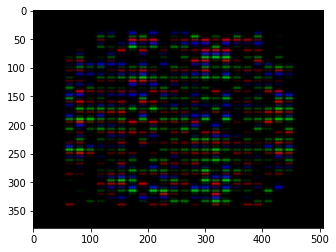

In [21]:
model.grayscale = False

# -- plot corresponding PSF
model.compute_intensity_psf()
learned_psf = model._psf.cpu().detach().numpy().squeeze()
if not model.grayscale:
    learned_psf = learned_psf.transpose(1, 2, 0)
# learned_psf = model.psf(numpy=True)

gamma = 2.2
print(learned_psf.shape)
plot_image(learned_psf, gamma=gamma, normalize=True);

## Lensless reconstruction

psf_fp = "../psfs/tape.png" above

In [106]:
""" prepare data """ 
from lensless.io import load_psf
from lensless.util import rgb2gray

psf = load_psf(fp=psf_fp, shape=img_data.shape[:2])

if grayscale:
    psf = rgb2gray(psf)
print(psf.shape)

img_data_norm = img_data / img_data.max()
# img_data_norm = img_data / np.linalg.norm(img_data.ravel())


# from lensless.util import resize
# import cv2

# # psf = resize(psf_data, 3 / 19, interpolation=cv2.INTER_CUBIC).astype(np.float32)[:, :, np.newaxis]
# psf = resize(psf_data, 1/ down, interpolation=cv2.INTER_CUBIC).astype(np.float32)[:, :, np.newaxis]

# print(psf.shape)

# img_data_norm = img_data / img_data.max()
# # img_data_norm = img_data / np.linalg.norm(img_data.ravel())

(47, 63)


Setup time : 0.004727363586425781 s
Processing time : 0.2806520462036133 s


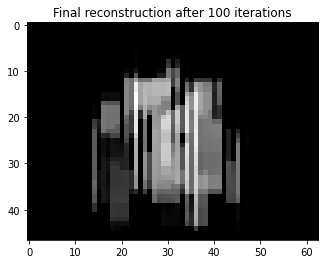

In [107]:
import time
from lensless import ADMM

n_iter = 100
disp = n_iter + 1
gamma = 2.2

start_time = time.time()
recon = ADMM(psf[:, :, np.newaxis])
recon.set_data(img_data)
print(f"Setup time : {time.time() - start_time} s")

start_time = time.time()
res = recon.apply(n_iter=n_iter, disp_iter=disp, gamma=gamma, plot=True)
print(f"Processing time : {time.time() - start_time} s")

In [94]:
import time
from lensless import ADMM

n_iter = 50
disp = n_iter + 1
gamma = 1

start_time = time.time()
recon = ADMM(psf)
recon.set_data(img_data)
print(f"Setup time : {time.time() - start_time} s")

start_time = time.time()
res = recon.apply(n_iter=n_iter, disp_iter=disp, gamma=gamma, plot=True)
print(f"Processing time : {time.time() - start_time} s")

AssertionError: 

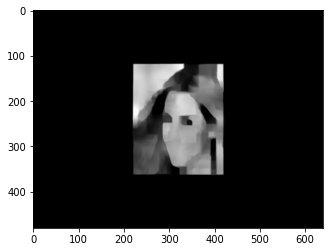

In [ ]:
ax = plot_image(res[0], gamma=1)

Setup time : 0.3284645080566406 s
Processing time : 4.261462211608887 s


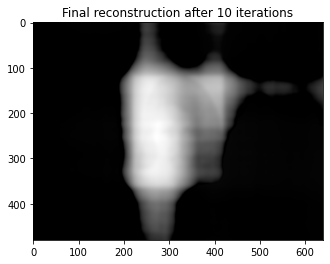

In [24]:
n_iter = 10
disp = n_iter + 1
gamma = 2.2

start_time = time.time()
recon = ADMM(psf)
recon.set_data(img_data)
print(f"Setup time : {time.time() - start_time} s")

start_time = time.time()
res = recon.apply(n_iter=n_iter, disp_iter=disp, gamma=gamma, plot=True)
print(f"Processing time : {time.time() - start_time} s")

#### compare with original

(218, 178, 3)


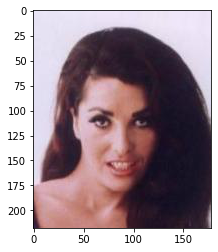

In [25]:
from torchvision import transforms, datasets

# compare with original
ds = datasets.CelebA(
    root="../data",
    split="all",
    download=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0,), (1,))]
    ),
)

img, label = ds[dataset_idx]
# if grayscale:
#     img_data = img.cpu().clone().numpy().squeeze()
# else:
img_data = img.cpu().clone().numpy().transpose(1, 2, 0)
print(img_data.shape)
plot_image(img_data);


# Load already prepared dataset

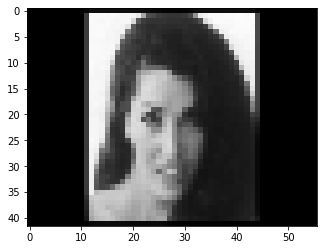

In [27]:
from lenslessclass.datasets import CelebAAugmented

dataset = "../data/celeba_lens_outdim2352_height0.27_scene2mask0.55_speckle40.0_croppsf100_202599files"

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
all_data = CelebAAugmented(path=dataset, transform=trans)

input_image, label = all_data[dataset_idx]
input_image_cpu = np.transpose(input_image.cpu(), (1, 2, 0))
plot_image(input_image_cpu, gamma=gamma, normalize=True);

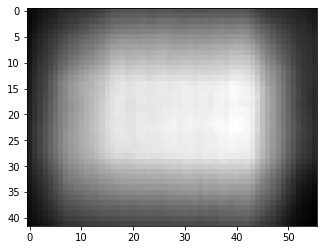

In [28]:
from lenslessclass.datasets import CelebAAugmented

dataset = "../data/celeba_tape_outdim2352_height0.27_scene2mask0.55_speckle40.0_202599files"

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
all_data = CelebAAugmented(path=dataset, transform=trans)

input_image, label = all_data[dataset_idx]
input_image_cpu = np.transpose(input_image.cpu(), (1, 2, 0))
plot_image(input_image_cpu, gamma=gamma, normalize=True);

# SLM output

In [1]:
from lenslessclass.datasets import CelebAPropagated
import numpy as np
from lensless.plot import plot_image

psf_fp = "../psfs/adafruit.png"
crop_psf = False
mask2sensor = 4e-3

output_dim = (480, 640)
noise_type = "poisson"
# noise_type = False
snr = 40

down_psf = 1
object_height = 0.27
grayscale = True
single_psf = False

scene2mask = 40e-2
scene2mask = 55e-2

device_conv = "cuda:1"
# device_conv = "cpu"

sensor = "rpi_hq"
attribute = "Male"

ds_aug = CelebAPropagated(
    psf_fp=psf_fp,
    attribute=attribute,
    downsample_psf=down_psf,
    output_dim=output_dim,
    scene2mask=scene2mask,
    mask2sensor=mask2sensor,
    sensor=sensor,
    object_height=object_height,
    device_conv=device_conv,
    crop_psf=crop_psf,
    grayscale=grayscale,
    vflip=False,
    split="all",
    single_psf=single_psf,
    root=CELEBA_ROOT_DIR,
    noise_type=noise_type,
    snr=snr
)

NameError: name 'CELEBA_ROOT_DIR' is not defined

(3040, 4056, 1)


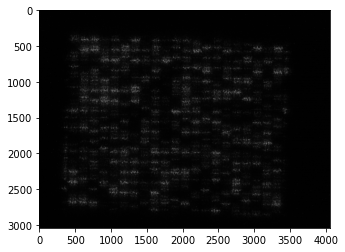

In [7]:
# plot PSF
psf_data = ds_aug.psf.cpu().clone().numpy().transpose(1, 2, 0)
print(psf_data.shape)
ax = plot_image(psf_data, gamma=4);

(480, 640, 1)
tensor(0)


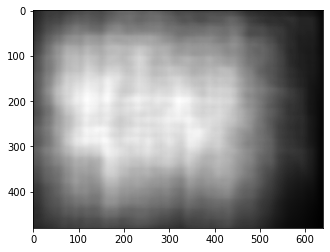

In [8]:
# plot simulated
dataset_idx = 10
img, label = ds_aug[dataset_idx]
# if grayscale:
#     img_data = img.cpu().clone().numpy().squeeze()
# else:
img_data = img.cpu().clone().numpy().transpose(1, 2, 0)
print(img_data.shape)
print(label)
plot_image(img_data);

(480, 640, 1)
Setup time : 0.3940751552581787 s
Processing time : 48.28205704689026 s


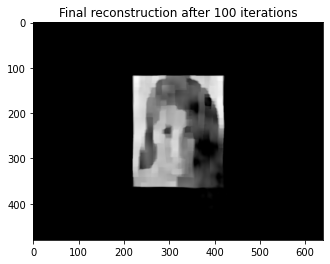

In [9]:
# lensless reconstruction
from lensless.util import resize
import cv2
import time
from lensless import ADMM


n_iter = 100
disp = n_iter + 1
gamma = 2.2

psf = resize(psf_data, 3 / 19, interpolation=cv2.INTER_CUBIC).astype(np.float32)[:, :, np.newaxis]
print(psf.shape)
img_data_norm = img_data / img_data.max()


start_time = time.time()
recon = ADMM(psf)
recon.set_data(img_data)
print(f"Setup time : {time.time() - start_time} s")

start_time = time.time()
res = recon.apply(n_iter=n_iter, disp_iter=disp, gamma=gamma, plot=True)
print(f"Processing time : {time.time() - start_time} s")

# noise

In [39]:
img_data.max()

255

(480, 640, 1)
0.2504289215686275


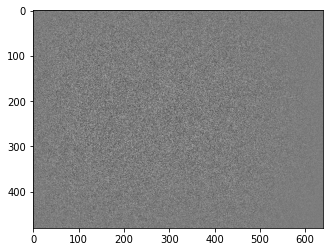

In [43]:
from skimage.util.noise import random_noise
import numpy as np

# example speckle noise
# noise = np.random.poisson(img_data)

img_data_norm = img_data / img_data.max()

noise = random_noise(
    img_data_norm,
    mode="poisson",
    clip=False,
    # mean=0,
    # var=0.001,
) - img_data_norm
print(noise.shape)
print(noise.max())
plot_image(noise);

In [48]:
from scipy import ndimage

sig_var = ndimage.variance(img_data_norm)
noise_var = ndimage.variance(noise)
snr = 10 * np.log10(sig_var / noise_var)
print(snr)

target_snr = 40
fact = np.sqrt(sig_var / noise_var / (10 ** (target_snr / 10)))
print(fact)

sig_var = ndimage.variance(img_data_norm)
noise_var = ndimage.variance(fact * noise)
snr = 10 * np.log10(sig_var / noise_var)
print(snr)

15.277046963866178
0.05805670023021492
40.0


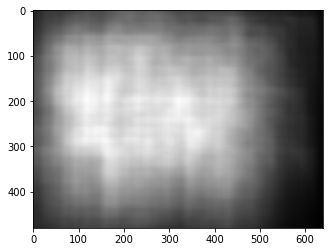

In [50]:
plot_image(img_data_norm + fact * noise);

torch.Size([1, 480, 640])
0.0034126989454137035
(480, 640, 1)


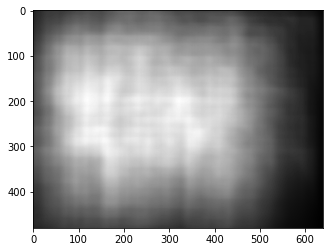

In [63]:
# use torch Poisson: https://pytorch.org/docs/stable/generated/torch.poisson.html
from torch import poisson

img_norm = img.to(dtype=torch.float32) / img.max()

noise_torch = poisson(img_norm)
print(noise_torch.shape)

target_snr = 40
sig_var = ndimage.variance(img_norm.numpy())
noise_var = ndimage.variance(noise_torch.numpy())
fact = np.sqrt(sig_var / noise_var / (10 ** (target_snr / 10)))
print(fact)

noisy_image = img_norm + fact * noise_torch

noisy_image_np = noisy_image.cpu().clone().numpy().transpose(1, 2, 0)
print(noisy_image_np.shape)
plot_image(noisy_image_np);